
<center><h1>Pyramid Scene Parsing Network for Semantic Segmentation </h1></center>

* Pyramid scene parsing network(PSPNet) takes into account the global context of the image to predict the local level predictions hence gives better performance when compared to other state of the art networks
* Scene parsing is based on semantic segmentation, Where the goal is to assign each pixel in the image a category label where Scene parsing provides a complete understanding of the scene.
* The Pyramid Scene Parsing Network(Pspnet) consists of a pyramid pooling module as an effective global context prior which represents global context information and also considers sub-region context which is helpful for accurate prediction.
<br>For more information please refer the paper [Pyramid Scene Parsing Network](https://arxiv.org/pdf/1612.01105.pdf) and its summary [here](https://drive.google.com/file/d/1ZCF1LswaDdseXi5vpBCgolxdi9GSy7-M/view?usp=sharing)
* The pspnet is described in below image as below<br>
(a)	Input image (b)	Feature map (c)	Pyramid pooling module (d) Final Prediction

<img src="https://imgur.com/qgH3Axv.png">

<u>**Implementation Overview:**<br></u>
<pre>
(a)Input image:
    (i) This is the input image with some resolution
(b)Feature map:
    (i) Feature map can be obtained by using Restnet with dilated convolutions aka atrous convolution which is the<br>        same as Deep_lab network strategy.
    (ii) The final output size of the feature map should be ⅛ size of the input image
(c)Pyramid parsing module:
    (i) Global average pooling and Sub average pooling is applied to feature maps to get different sub-region <br>        representations as Sub-regions: Red:1x1, Orange:2x2, Blue:3x3, Green:6x6.
    (ii) 1x1 convolution is applied to reduce the context of feature map to 1/number of the subregion that is ¼.
    (iii) Upsampling is performed on subregions to get the size same as original feature map and finally, all <br>          feature maps are concatenated to get the final feature representation, which carries both local <br>          and global context information.
(d) Final Prediction: The final representation is fed into a convolution layer to get the final prediction.</pre>

### Importing required Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from numpy import asarray,zeros,moveaxis
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from sys import getsizeof
from keras.callbacks import TensorBoard
from tqdm import tqdm_notebook,tqdm
from sklearn.metrics import *
import os,sys,ntpath,fnmatch,shutil,cv2
import joblib,os.path,itertools,warnings
from keras.models import load_model 
from scipy.sparse import csc_matrix
import numpy as np
import pandas as pd
from os import path
!pip install import_ipynb
from IPython.display import clear_output
from time import time
np.random.seed(0)
from google.colab import drive
drive.mount('/content/drive')
! cp -v "/content/drive/My Drive/IID_Files/Utility_Functions.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/Final.ipynb" "/content" 
! cp -v "/content/drive/My Drive/IID_Files/IID_Data_Prep_Utils.ipynb" "/content"  
warnings.filterwarnings("ignore")
clear_output()

### Importing Data Preparation Modules

In [ ]:
import import_ipynb 
from Utility_Functions import *
from Final import *
from IID_Data_Prep_Utils import *

Checking Status:
------------------------------------------------------
1.Image Data Preparation     .. .. .. >>> |Done| <1/5>
2.Label Mask Preparation     .. .. .. >>> |Done| <2/5>
3.Data Shuffling             .. .. .. >>> |Done| <3/5>
4.Data Train_Test_Split      .. .. .. >>> |Done| <4/5>
5.Loading Final Data         .. .. .. >>> |Done| <5/5>
------------------------------------------------------

Gen RAM Free: 2.41 GB  - Used: 23.22 GB - Total : 25.51 GB - Util  91.02 %
GPU RAM Free: 15.9 GB  - Used: 0.0 GB - Total : 15.9 GB  - Util  0.0 %


### General Utility Function for Prediction

In [ ]:
def predict_for(data_for_prediction, weights_save_path=False):

    """  General Function to perform prediction for the specified data split  """

    Mean_MIoU, Accuracy, cf_matrix=[], [], np.zeros((7,7))
    x, y = Load_For_Prediction(data_for_prediction)
    Model, Skip = Select_Model(weights_save_path), 2
    
    for d in tqdm_notebook(range(0,len(x),Skip)):

        if (d>=(len(x)-Skip)): 
            plot,_,_=True,clear_output(),print("Total number of samples in {0} : {1}".format(data_for_prediction,len(x)))
        else: plot=False
        
        Miou, cf_matrix, Accuracy=Function_2(x[d:d+Skip],y[d:d+Skip],Mean_MIoU,cf_matrix,Accuracy,Model,plot,False,False,False)
    collected = gc.collect()
    
    return Miou, Accuracy, cf_matrix

### Implementation of Pyramid Scene Parsing Network (PSPNET)

In [ ]:
def PSPNET(Input_shape, n_classes):  

    """
    Function to build Pyramid Scene Parsing Network for Image Segmentation
    Input  : input_shape <Tuple>, n_classes <Int>
    Return : model """  
    
    def Restnet50_Module(Input_layer, n_classes):

        """
        Function to Build RestNet for PSPNET Architecture to perform Image Segmentation
        Input  : Input_layer <keras.layer>, n_classes <Int>
        Return : Block5_3_ID <keras.layer> """
        
        def Restnet_Conv_Block(Block_Number,Name,Filters,Previous_layer,initialize="he_normal"):

            """
            Function to Build RestNet Convolution Blocks  
            Input  : Block_Number <Int>, Name <String>, Filters <List>, Previous_layer <keras.layer>, initialize <String>
            Return : Final_Conv <keras.layer> """
            
            # Defining strides values Based on Block_Number
            strides=(1,1) if Block_Number==2 else (2,2)
            
            # Defining Dilated Rate Based on Block_Number
            if (Block_Number==4):
                D_Rate=2
            elif (Block_Number==5):
                D_Rate=4
            else:
                D_Rate=1
            
            # Defining First Convolution layer with Batch Normalization for RestNet Convolution Block  
            Convolution1 = tf.keras.layers.Conv2D(Filters[0],(1,1), strides=strides, name= Name+"Conv1", activation = 'relu', kernel_initializer=initialize)(Previous_layer)
            Batch_norm1=tf.keras.layers.BatchNormalization()(Convolution1)
            
            # Defining Second Convolution layer with Batch Normalization for RestNet Convolution Block  
            Convolution2 = tf.keras.layers.Conv2D(Filters[1],(3,3), dilation_rate=D_Rate, name= Name+"Conv2", padding='same', activation = 'relu', kernel_initializer=initialize)(Batch_norm1)
            Batch_norm2=tf.keras.layers.BatchNormalization()(Convolution2)
            
            # Defining Third Convolution layer with Batch Normalization for RestNet Convolution Block
            Convolution3 = tf.keras.layers.Conv2D(Filters[2],(1,1),name= Name+"Conv3", activation = None, kernel_initializer=initialize)(Batch_norm2)
            Batch_norm3=tf.keras.layers.BatchNormalization()(Convolution3)
            
            # Defining Convolution layer with Batch Normalization for RestNet Convolution Block  
            Layer_to_add = tf.keras.layers.Conv2D(Filters[2],(1,1), strides=strides, name= Name+"conv_prep_add", activation = None, kernel_initializer=initialize)(Previous_layer)
            Layer_to_add=tf.keras.layers.BatchNormalization()(Layer_to_add)
            
            # Defining Skip Connection for RestNet Convolution Blocks  
            Added_Layer=tf.keras.layers.add([Batch_norm3,Layer_to_add])
            Final_Conv=tf.keras.layers.Activation("relu")(Added_Layer)
            
            return Final_Conv
            
        def Restnet_Id_Block(Block_Number,Name,Filters,Previous_layer,initialize="he_normal"):
            
            """
            Function to Build RestNet Identity Blocks  
            Input  : Block_Number <Int>, Name <String>, Filters <List>, Previous_layer <keras.layer>, initialize <String>
            Return : Final_Conv1 <keras.layer>  """

            # Defining Dilated Rate Based on Block_Number
            if (Block_Number==4):
                D_Rate=2
            elif (Block_Number==5):
                D_Rate=4
            else:
                D_Rate=1
            
            # Defining First Convolution layer with Batch Normalization for RestNet Identity Block                
            Convolution1 = tf.keras.layers.Conv2D(Filters[0], (1,1), name= Name+"Conv1", activation = 'relu', kernel_initializer=initialize)(Previous_layer)
            Batch_norm1=tf.keras.layers.BatchNormalization()(Convolution1)
            
            # Defining Second Convolution layer with Batch Normalization for RestNet Identity Block 
            Convolution2 = tf.keras.layers.Conv2D(Filters[1], (3,3), dilation_rate=D_Rate, name= Name+"Conv2", padding='same', activation = 'relu', kernel_initializer=initialize)(Batch_norm1)
            Batch_norm2=tf.keras.layers.BatchNormalization()(Convolution2)
            
            # Defining Third Convolution layer with Batch Normalization for RestNet Identity Block
            Convolution3 = tf.keras.layers.Conv2D(Filters[2], (1,1), name= Name+"Conv3", activation = None, kernel_initializer=initialize)(Batch_norm2)
            Batch_norm3=tf.keras.layers.BatchNormalization()(Convolution3)
            
            # Defining Skip Connection for RestNet Identity Block
            Added_Layer=tf.keras.layers.add([Batch_norm3,Previous_layer])
            Final_Conv1=tf.keras.layers.Activation("relu")(Added_Layer)

            return Final_Conv1
        
        # Building RestNet Block-1
        Block_1_Conv = tf.keras.layers.Conv2D(64,(7,7),strides=(2,2),name= "Block1_Conv1", activation = 'relu', padding='same', kernel_initializer="he_normal")(Input_layer)
        Block_1_Batch_norm1=tf.keras.layers.BatchNormalization(name="Block1_Conv1_BN")(Block_1_Conv)
        Block_1_MaxPool = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2), name="Block1_Maxpool1", padding='same')(Block_1_Batch_norm1)

        # Building RestNet Block-2 
        Block2_1_con= Restnet_Conv_Block(2, "Block2.1_CONV_", [16,16,64], Block_1_MaxPool)
        Block2_2_ID= Restnet_Id_Block( 2,  "Block2.2_ID_",    [16,16,64], Block2_1_con)
        Block2_3_ID= Restnet_Id_Block( 2,  "Block2.3_ID_",    [16,16,64], Block2_2_ID)

        # Building RestNet Block-3
        Block3_1_con= Restnet_Conv_Block(3, "Block3.1_CONV_", [32,32,128], Block2_3_ID)
        Block3_2_ID= Restnet_Id_Block( 3,   "Block3.2_ID_",   [32,32,128], Block3_1_con)
        Block3_3_ID= Restnet_Id_Block( 3,   "Block3.3_ID_",   [32,32,128], Block3_2_ID)
        Block3_4_ID= Restnet_Id_Block( 3,   "Block3.4_ID_",   [32,32,128], Block3_3_ID)

        # Building RestNet Block-4
        Block4_1_con= Restnet_Conv_Block(4, "Block4.1_CONV_", [64,64,256], Block3_4_ID)
        Block4_2_ID= Restnet_Id_Block( 4,   "Block4.2_ID_",   [64,64,256], Block4_1_con)
        Block4_3_ID= Restnet_Id_Block( 4,   "Block4.3_ID_",   [64,64,256], Block4_2_ID)
        Block4_4_ID= Restnet_Id_Block( 4,   "Block4.4_ID_",   [64,64,256], Block4_3_ID)
        Block4_5_ID= Restnet_Id_Block( 4,   "Block4.5_ID_",   [64,64,256], Block4_4_ID)
        Block4_6_ID= Restnet_Id_Block( 4,   "Block4.6_ID_",   [64,64,256], Block4_5_ID)
        
        # Building RestNet Block-5
        Block5_1_con= Restnet_Conv_Block(5, "Block5.1_CONV_", [128,128,512], Block4_6_ID)
        Block5_2_ID= Restnet_Id_Block( 5,   "Block5.2_ID_",   [128,128,512], Block5_1_con)
        Block5_3_ID= Restnet_Id_Block( 5,   "Block5.3_ID_",   [128,128,512], Block5_2_ID)
        
        return Block5_3_ID

    def Pyramid_Module(Rest50_Layer):
        
        """  Function to Build Pyramid Pooling Module  """
        
        def Feature_Sub_Map(Sub_block, Pool_size, Previous_layer, filters=128):

            """  
            Fuction to build Parallel Sub-pooling Operations of Pyramid Pooling Module  
            Input  : Sub_block <Int>, Pool_size <Tuple>, Previous_layer <keras.layer>, Filters <Int>
            Return : Retn_Sub <keras.layer>  """
            
            # Defining Sub-pooling operation Based on Sub_block Number
            if Sub_block == "RED":
                Pool_size = (Previous_layer.shape[1],Previous_layer.shape[2])
                Sub_pool = tf.keras.layers.GlobalAveragePooling2D(name= Sub_block+'_GL_POOL')(Previous_layer)
                Sub_pool = tf.keras.layers.Reshape((1,1,Previous_layer.shape[3]))(Sub_pool)
            else:
                Sub_pool = tf.keras.layers.AveragePooling2D(pool_size=Pool_size,name= Sub_block+'_AVG_POOL')(Previous_layer)
            
            # Defining Convolution layer with Batch Normalization for Pyramid Pooling Module
            Conv_sub = tf.keras.layers.Convolution2D(filters=filters,kernel_size=(1,1),name= Sub_block+'Conv1_1')(Sub_pool)
            Conv_sub=tf.keras.layers.BatchNormalization()(Conv_sub)
            Retn_Sub = tf.keras.layers.UpSampling2D(size=Pool_size, name=Sub_block+'Up_sample',interpolation='bilinear')(Conv_sub)
            
            return Retn_Sub
        
        # UpSampling Features to some sensible Size
        Rest50_Layer = UpSampling2D(size=(4,4),interpolation='bilinear',name='Size_Adjust_samp')(Rest50_Layer)
        Rest50_Layer=tf.keras.layers.ZeroPadding2D((2,0),name='up_Size_Adjust_pad')(Rest50_Layer)
        
        # building Pyramid Pooling Module with Sub-pooling
        Red_Map= Feature_Sub_Map(    "RED",   (1,1), Rest50_Layer)
        Orange_Map= Feature_Sub_Map("ORANGE", (2,2), Rest50_Layer)
        Blue_Map= Feature_Sub_Map(   "BLUE",  (3,3), Rest50_Layer)
        Green_Map= Feature_Sub_Map(  "GREEN", (6,6), Rest50_Layer)

        # Concatenating of all Parallel Sub-pooling layers to get concatenated features
        Global_Concat= tf.keras.layers.concatenate([Rest50_Layer, Green_Map, Blue_Map, Orange_Map, Red_Map])

        # UpSampling Pyramid Pooling Features to Orginal size of Network input
        UpSampling = tf.keras.layers.UpSampling2D(size=(6,8),interpolation='bilinear',name='en_Size_Adjust_samp')(Global_Concat)
        Convolution1 = tf.keras.layers.Conv2D(64, (5,5),name= "Conv1", activation = 'relu', padding="same",kernel_initializer="he_normal")(ZeroPadding2D((12,0))(UpSampling))
        Convolution1=tf.keras.layers.BatchNormalization()(Convolution1)

        # Final Convolution layer with number of classes as filter size followed by softmax Layer
        Convolution2 = tf.keras.layers.Conv2D(7, (3,3),name= "Conv2",activation = 'relu', padding="same",kernel_initializer="he_normal")(Convolution1)
        Output=Activation('softmax', name="Softmax")(Convolution2)
        
        return Output
    
    # Defining input layer of PSPNET  
    Input_layer = tf.keras.layers.Input(shape=Input_shape)

    # Invoking Restnet50_Module() for Restnet50
    Rest50_Layer = Restnet50_Module(Input_layer, n_classes)
    
    # Invoking Pyramid_Module() for Pyramid pooling Module
    Output = Pyramid_Module(Rest50_Layer)
    
    # Defining Model with Input and Output Layer 
    PSPNET_Model = Model(Input_layer, Output)
    
    return PSPNET_Model

# Invoking PSPNET() to get PSPNET Model
Input_shape, n_classes = (240, 480,3), 7
Pspnet_Model=PSPNET(Input_shape, n_classes)

### Training Pspnet Model

In [ ]:
# Get current Time
start_time = time()

# Defining Batch size and epoch 
batch_size, epochs = 8, 30

# Defining tensorboard to store Training Information and filepath to store PSPNET model 
tensorboard, filepath = TensorBoard(log_dir=root+"logs/pspnet_{}".format(str(time())[5:10])), root+"/Pspnet.best.hdf5"

# Defining steps_per_epoch and validation_steps for Training
steps_per_epoch, validation_steps = int((len(train_img_files1)+len(train_img_files2))/batch_size), int((len(val_img_files1)+len(val_img_files2))/batch_size)

# Compile PSPNET Model
Pspnet_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy',metrics = ['accuracy',miou])

# Defining EarlyStopping with patience=3 and monitor='val_miou'
es = EarlyStopping(monitor='val_miou', mode='max', verbose=1, patience=3)

# Defining ModelCheckpoint with monitor as 'val_miou'
checkpoint = ModelCheckpoint(filepath, monitor='val_miou', verbose=2, save_best_only=True, mode='max')

# Defining ReduceLROnPlateau to reduce learning rate with patience=2
learning_rate_reduction = ReduceLROnPlateau(monitor='val_miou', patience=2, verbose=2, factor=0.2, min_lr=0.0005)

# Fit PSPNET Model to start training 
history = Pspnet_Model.fit_generator(train_batch_generator(batch_size,epochs), steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, validation_data=val_batch_generator(batch_size,epochs),
                            validation_steps=validation_steps, callbacks=[learning_rate_reduction,checkpoint,es,tensorboard])

# Printing Time taken for Training 
print("--- %s seconds ---" % (time() - start_time))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
   1/1753 [..............................] - ETA: 0s - loss: 1.9719 - accuracy: 0.1705 - miou: 0.0737WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1753/1753 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.7208 - miou: 0.3652
Epoch 00001: val_miou improved from -inf to 0.37707, saving model to /content/drive/My Drive/Pspnet.best.hdf5
1753/1753 [==============================] - 6250s 4s/step - loss: 0.7414 - accuracy: 0.7208 - miou: 0.3652 - val_loss: 0.6776 - val_accuracy: 0.7379 - val_miou: 0.3771
Epoch 2/50
1753/1753 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.7675 - miou: 0.4429
Epoch 00002: val_miou improved from 0.37

### Pspnet Training Results

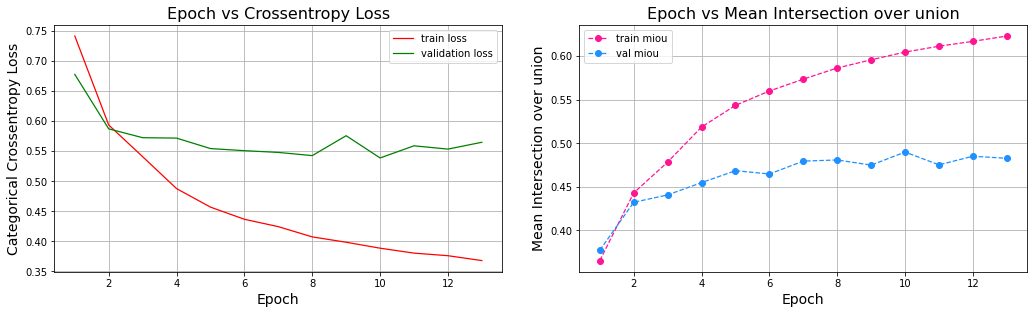

In [ ]:
# training_result
plot_training_result(history)

* The Lowest value of Validation Categorical Crossentopy is 0.4898 which is at epoch-10 as above in the Graph.
* The Best Value of Validation Mean Intersection Over Union is 0.5386 which is at epoch-10 as above in the Graph.
* Keras callback ModelCheckpoint is used to save the best Model during Training to avoid overfitting.

### Pspnet Prediction on Train Data

Total number of samples in Train_data : 10016

Few Segmentation Samples:>>>



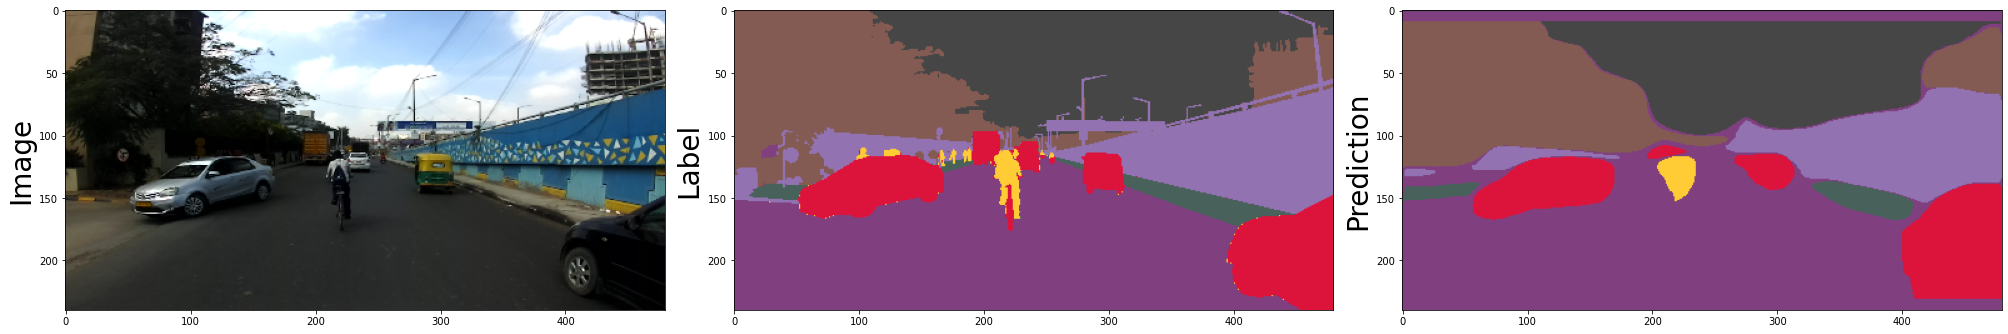

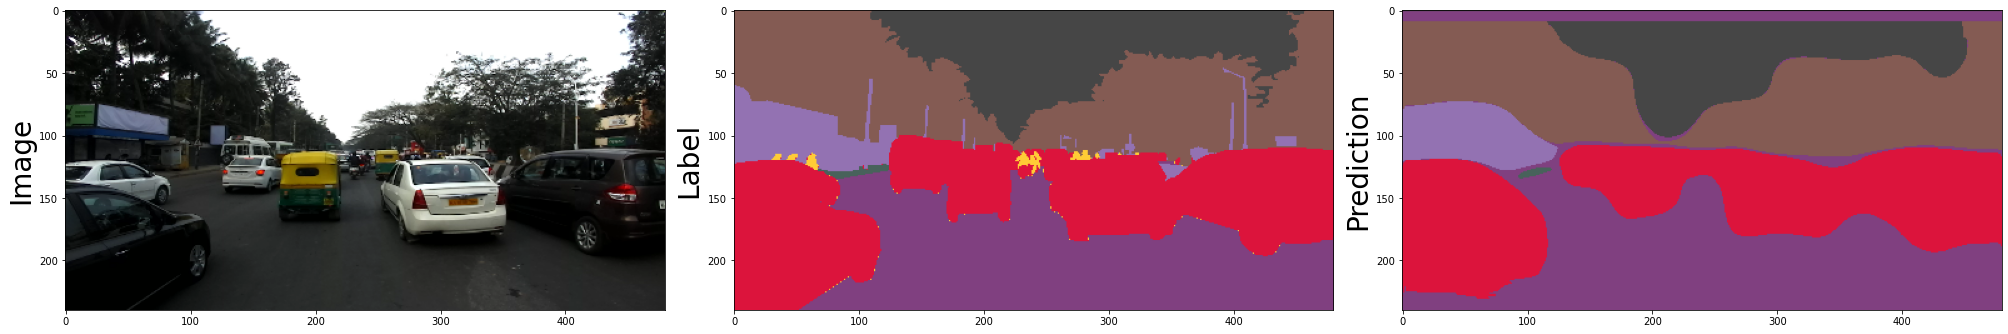


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.4612

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.8225

-----------------------
|  Confusion Matrix   |
-----------------------


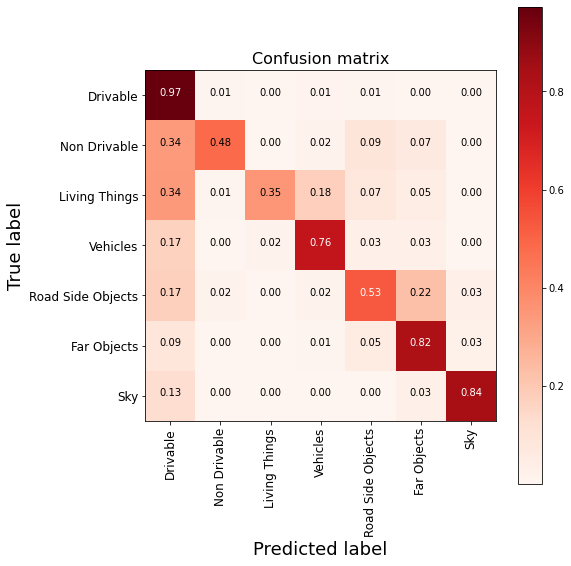

In [ ]:
# Train Prediction 
Miou, Accuracy, cf_matrix = predict_for("Train_data")

### Pspnet Prediction on Validation Data

Total number of samples in Val_data : 2036

Few Segmentation Samples:>>>



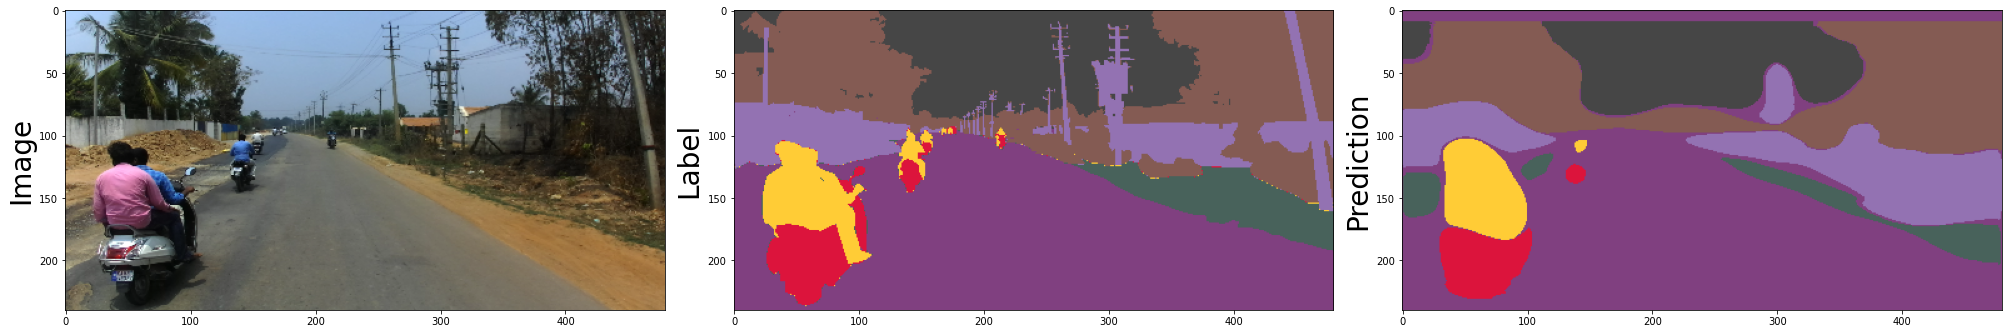

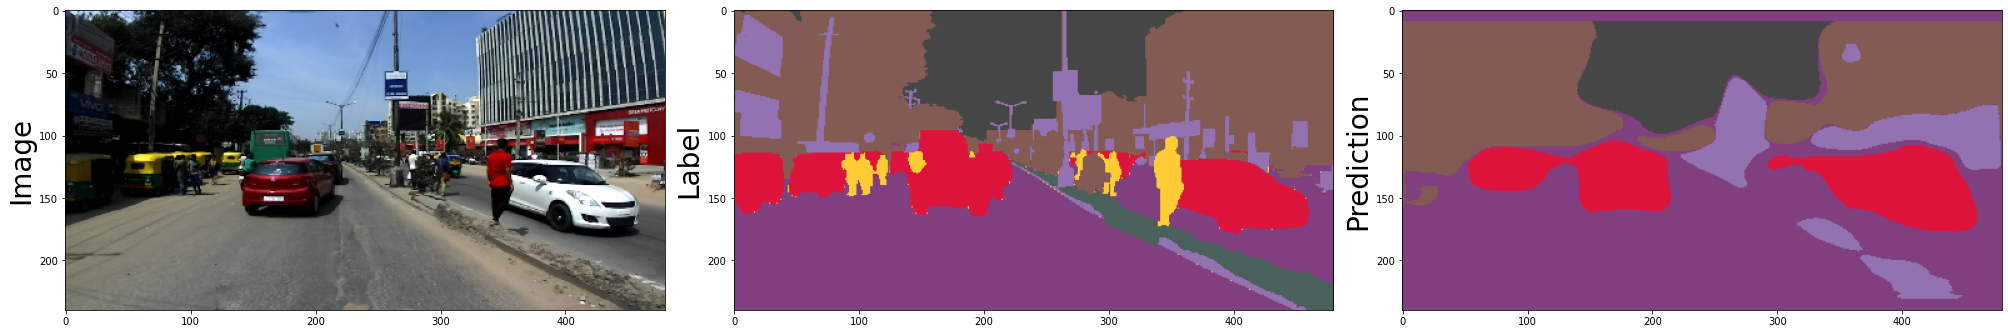


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.4201

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.7796

-----------------------
|  Confusion Matrix   |
-----------------------


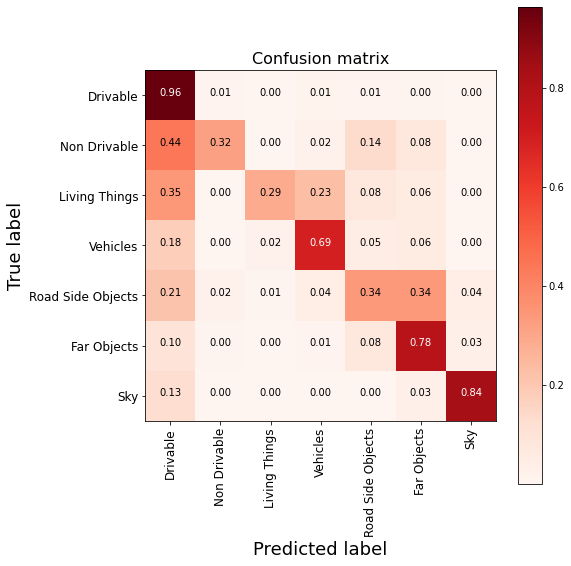

In [ ]:
# Validation Prediction 
Miou, Accuracy, cf_matrix = predict_for("Val_data")

### Pspnet Prediction on Test Data

Total number of samples in Test_data : 4011

Few Segmentation Samples:>>>



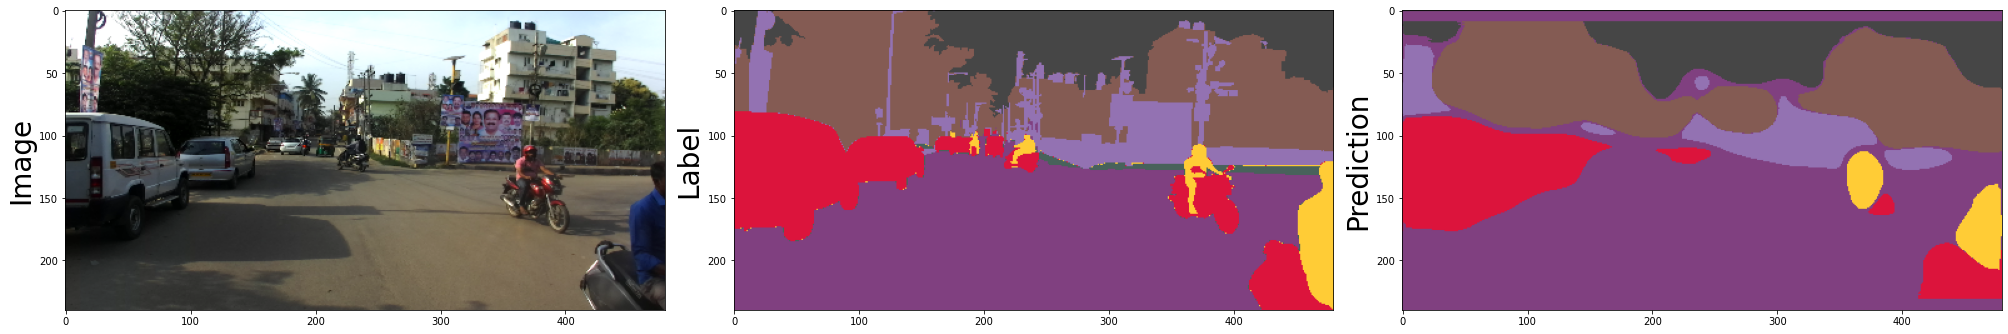


Printing Results:>>

-----------------------
|      MIOU Score     |
-----------------------

   MIOU Score: 0.4284

-----------------------
|   Accuracy Score   |
-----------------------

   Accuracy Score: 0.7941

-----------------------
|  Confusion Matrix   |
-----------------------


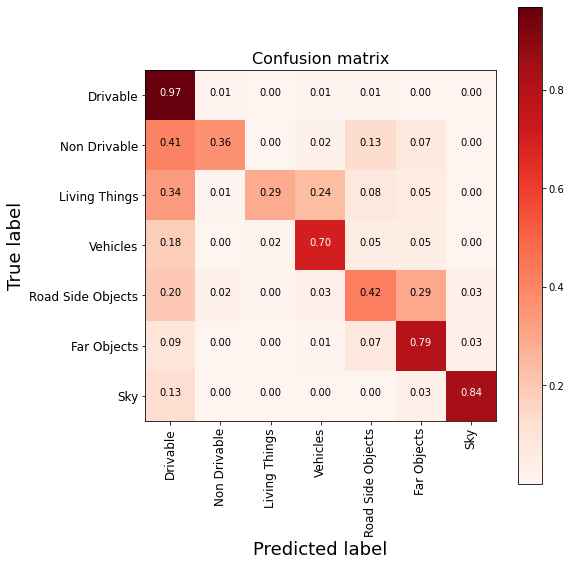

In [ ]:
# Test Prediction 
Miou, Accuracy, cf_matrix = predict_for("Test_data")

### Pretty Tabel


In [ ]:
# https://ptable.readthedocs.io/en/latest/tutorial.html
print("\n\t     Performance Table")
from prettytable import PrettyTable
T = PrettyTable()
T.field_names = ["PspNet","MIOU", "Accuracy"]
T.add_row(["Train ","0.4612","0.8225"])
T.add_row([" ---------- ","----------","----------"])
T.add_row(["Validation ","0.4201","0.7796"])
T.add_row([" ---------- ","----------","----------"])
T.add_row(["Test ","0.4284","0.7941"])
print(T)


	     Performance Table
+--------------+------------+------------+
|    PspNet    |    MIOU    |  Accuracy  |
+--------------+------------+------------+
|    Train     |   0.4612   |   0.8225   |
|  ----------  | ---------- | ---------- |
| Validation   |   0.4201   |   0.7796   |
|  ----------  | ---------- | ---------- |
|    Test      |   0.4284   |   0.7941   |
+--------------+------------+------------+


### <u>**Conclusion:**</u>
* PspNet is an effective network for complex scene understanding with a global pyramid pooling that provides contextual information.
* PspNet has misclassified many of the labels due to fewer Filters used while training because of limited availability of hardware.
* PspNet architecture achieves relatively lower performance on Image segmentation when compared to other segmentation models.
* More performance can be obtained by training Models with data in high resolution with more powerful hardware resources
